# Multivariate Gaussian samplers in Mamba

## Multivariate Gaussians and linear predictors

Many statistical models incorporate _linear predictor_ expressions of the form $\bf{X\beta}$ where $\bf{X}$ is an $n\times p$ _model matrix_ and $\bf{\beta}$ is a $p$-dimensional coefficient vector.  For example, an linear regression model can be written
$$
\mathcal{Y} \sim \mathcal{N}({\bf X}\beta,\sigma^2 {\bf I}_n)
$$
where $\mathcal{Y}$ is the $n$-dimensional response random variable, ${\bf I}_n$ is the identity matrix of size $n$ and $\mathcal{N}$ denotes the multivariate normal, or _Gaussian_, distribution.

The combination of linear predictors and multivariate Gaussian distributions allows for considerable simplification of many samplers, because a linear combination of a multivariate Gaussian random variate is also a multivariate Gaussian.

For example, with a "locally uniform" or "flat" prior on $\beta$, the conditional distribution, $\beta|\sigma^2,y$, is multivariate Gaussian
$$
\beta|\sigma^2,{\bf y} \sim \mathcal{N}\left(({\bf X}'{\bf X})^{-1}{\bf X}'{\bf y}, \sigma^2({\bf X}'{\bf X})^{-1}\right)
$$

## The canonical parameterization

In the Bayesian approach it is often easier to express multivariate Gaussian distributions using the _precision matrix_, $\Sigma^{-1}$, instead of the _covariance matrix_, $\Sigma$.  There is a theoretical basis for doing so in that the multivariate Gaussian is a member of the [exponential family](http://en.wikipedia.org/wiki/Exponential_family) of distributions, each of which has a _canonical parameterization_.  In the case of the multivariate Gaussian the canonical parameters are the _potential vector_, $\Sigma^{-1}\mu$, and the precision, $\Sigma^{-1}$.

The [Distributions package](https://github.com/JuliaStats/Distributions.jl), which is widely used in [Mamba](https://github.com/brian-j-smith/Mamba.jl), provides univariate and multivariate normal distributions in both the location-scale parameters (`Normal` and `MvNormal`) and in the canonical parameters (`NormalCanon` and `MvNormalCanon`.  These distributions are useful for specifying prior distributions and for sampling from conditional distributions.

In [1]:
using Compat,DataFrames,Distributions,Gadfly,GraphViz,Mamba,PDMats

Suppose we wish to use a "diffuse" prior distribution for the coefficients $\beta$ instead of a flat prior.  Typically a diffuse prior is specified as a multivariate Gaussian with mean zero and a covariance which is a large multiple of the identity.  There is a special form of the `MvNormalCanon` constructed from the dimension and the (scalar) precision.

In [2]:
pri = MvNormalCanon(5,0.0001)

ZeroMeanIsoNormalCanon(
μ: ZeroVector{Float64}(5)
h: ZeroVector{Float64}(5)
J: ScalMat(5,0.0001,10000.0)
)


Because the mean, `μ`, is a zero vector, the potential, `h`, is also a zero vector.  The precision matrix, `J`, is a multiple of the identity matrix of size 5, for which there is a special type, `ScalMat`.

The special types allow for much more compact representation of common distribution types.  The `ZeroVector` type only stores the dimension and the `ScalMat` type only stores the dimension, the scale factor and its inverse.  It uses the same amount of storage if the dimension is 2 or 2000.  This can be important in avoiding storing and manipulating very large matrices.  Many precision matrices have simple forms, represented by types on the [PDMats package](https://github.com/JuliaStats/PDMats.jl)

## PDMats

A covariance matrix, $\Sigma$, must be symmetric and [positive semi-definite](http://en.wikipedia.org/wiki/Positive-definite_matrix).  The easiest way to characterize such a matrix is to say that its [eigenvalues](http://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors), which must be real numbers because $\Sigma$ is symmetric, are non-negative.  If all the eigenvalues are positive the matrix is _positive definite_.

Just as non-negative numbers have a square root, a positive semi-definite matrix, has "square roots", in the sense that there are matrices $\bf L$ such that $\Sigma={\bf LL}'$.  As indicated by the plural in "square roots" there are several such matrices when the size of $\Sigma$ is greater than 1.  The easiest such matrix, $\bf L$, to calculate is the [Cholesky factor](http://en.wikipedia.org/wiki/Cholesky_decomposition) which has the properties that $\bf L$ is lower triangular with non-negative diagonal elements.

A scalar normal distribution with mean $\mu$ and $\sigma^2=0$ is a trivial distribution (a point mass at $\mu$).  Generally we exclude such cases and require that $\sigma^2>0$.  Similarly we generally require covariance matrices, $\Sigma$, to positive definite, in which case, the precision matrix, $\Sigma^{-1}$ is also positive definite.

The `PDMats` package provides convenient ways of working with positive-definite matrices, especially those that have special structure.

## A Mamba model for linear regression

Let us consider the data from `Subject` 3 in the `sleepstudy` data set from the [lme4 package](https://github.com/lme4/lme4) for [R](http://www.r-project.org).

In [3]:
## sleepstudy data from lme4

const slp = DataFrame(Reaction =
   [249.56,258.7047,250.8006,321.4398,356.8519,414.6901,382.2038,
    290.1486,430.5853,466.3535,222.7339,205.2658,202.9778,204.707,
    207.7161,215.9618,213.6303,217.7272,224.2957,237.3142,199.0539,
    194.3322,234.32,232.8416,229.3074,220.4579,235.4208,255.7511,
    261.0125,247.5153,321.5426,300.4002,283.8565,285.133,285.7973,
    297.5855,280.2396,318.2613,305.3495,354.0487,287.6079,285.0,
    301.8206,320.1153,316.2773,293.3187,290.075,334.8177,293.7469,
    371.5811,234.8606,242.8118,272.9613,309.7688,317.4629,309.9976,
    454.1619,346.8311,330.3003,253.8644,283.8424,289.555,276.7693,
    299.8097,297.171,338.1665,332.0265,348.8399,333.36,362.0428,
    265.4731,276.2012,243.3647,254.6723,279.0244,284.1912,305.5248,
    331.5229,335.7469,377.299,241.6083,273.9472,254.4907,270.8021,
    251.4519,254.6362,245.4523,235.311,235.7541,237.2466,312.3666,
    313.8058,291.6112,346.1222,365.7324,391.8385,404.2601,416.6923,
    455.8643,458.9167,236.1032,230.3167,238.9256,254.922,250.7103,
    269.7744,281.5648,308.102,336.2806,351.6451,256.2968,243.4543,
    256.2046,255.5271,268.9165,329.7247,379.4445,362.9184,394.4872,
    389.0527,250.5265,300.0576,269.8939,280.5891,271.8274,304.6336,
    287.7466,266.5955,321.5418,347.5655,221.6771,298.1939,326.8785,                 
    346.8555,348.7402,352.8287,354.4266,360.4326,375.6406,388.5417,
    271.9235,268.4369,257.2424,277.6566,314.8222,317.2135,298.1353,
    348.1229,340.28,366.5131,225.264,234.5235,238.9008,240.473,
    267.5373,344.1937,281.1481,347.5855,365.163,372.2288,269.8804,
    272.4428,277.8989,281.7895,279.1705,284.512,259.2658,304.6306,
    350.7807,369.4692,269.4117,273.474,297.5968,310.6316,287.1726,
    329.6076,334.4818,343.2199,369.1417,364.1236],
Days = rep(0:9,18),
Subject = pool(rep(1:18,1,10)));

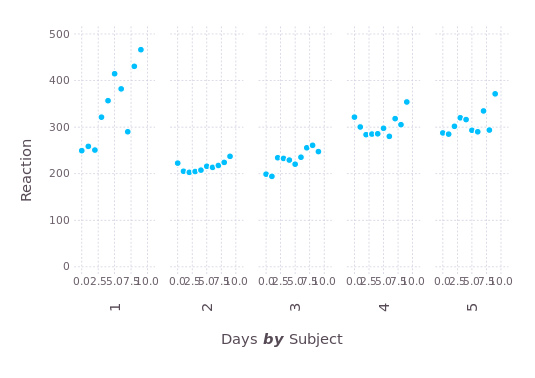

In [4]:
slp1to5 = slp[map(x -> x ∈ 1:5, slp[:Subject]),:];
plot(slp1to5,xgroup="Subject",x="Days",y="Reaction",
  Geom.subplot_grid(Geom.point))

In [5]:
slp3 = slp[slp[:Subject] .== 3,[:Reaction,:Days]]

,Reaction,Days
1,199.0539,0
2,194.3322,1
3,234.32,2
4,232.8416,3
5,229.3074,4
6,220.4579,5
7,235.4208,6
8,255.7511,7
9,261.0125,8
10,247.5153,9


In [6]:
const y = array(slp3[:Reaction]);
const X = hcat(ones(10),array(slp3[:Days]));
const Xty = X'y;
const XtX = PDMat(X'X);

In [7]:
lrmod = Model(
  y = Stochastic(1, @modelexpr(μ, σ², MvNormal(μ, √σ²)), false),
  μ = Logical(1, @modelexpr(X, β, XtX, Xty, X * β), false),
  β = Stochastic(1,:(MvNormalCanon(2,0.0001))),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)))
);

The conditional distribution of `β` given `σ²` and `y` is multivariate normal with potential vector `Xty / σ²` and precision matrix `XtX / σ² + β.distr.J`.  We may sample from this distribution directly.

In [8]:
Gibbs_β = Sampler([:β],
  @modelexpr(β, σ², XtX, Xty,
    rand(MvNormalCanon(Xty/σ², XtX/σ².value + β.distr.J))
  )
);

The reason for the expression `XtX/σ².value` instead of simply `XtX/σ²` is because of a missing method.

Similarly, the conditional distribution of `σ²` given `β` is an inverse Gamma distribution for which the scale and shape parameters are obtained by summing those from the likelihood contribution and the (conjugate) prior distribution. 

In [9]:
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(σ², μ, y, 
    begin
      dd = σ².distr
      shap = length(y) / 2 + shape(dd)
      scal = sumabs2(y - μ) / 2 + scale(dd)
      rand(InverseGamma(shap, scal))
    end)
);

The `sumabs2` function evaluates the sum of the squares of the elements of an array, in this case, the sum of squared residuals.

In practice the prior distribution has little effect on the resulting distribution.  The likelihood contribution only has a shape parameter that is half the number of responses so adding the shape parameter for the prior in this case changes the result from `5.0` to `5.001`.  Similarly the contribution from the prior for the scale parameter is to increment it slightly from half the sum of squared residuals.

We should be cautious here, however.  The sum of squared residuals depends on the scale of the response.  Here the `Reaction` time is in milliseconds.  If it were expressed as seconds the sum of squared residuals would be scaled by a factor of $10^{-6}$ and the scale parameter of the conditional distribution may be determined by the prior more than the likelihood.

We now set these samplers for the model and establish an associative array for the initial values.

In [10]:
setsamplers!(lrmod,[Gibbs_β, Gibbs_σ²]);
inputs = @compat Dict{Symbol,Any}(:X => X, :XtX => XtX, :Xty => Xty);
setinputs!(lrmod,inputs);

In [11]:
init = @compat(Dict{Symbol,Any}(:y => y,
  :β => XtX\Xty, :σ² => rand(Gamma(1,1))))

Dict{Symbol,Any} with 3 entries:
  :β…   => [203.48422545454562,6.114898787878757]
  :σ²…   => 0.38399499718037045
  :y  => [199.0539,194.3322,234.32,232.8416,229.3074,220.4579,235.4208,255.7511,…

In [12]:
setinits!(lrmod, init);

Next we check that the sampling seems to be working

In [13]:
simulate!(lrmod)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[203.63,6.09467]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
 10.0   45.0
 45.0  285.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 3.16228  14.2302 
 0.0       9.08295)
-------------------------------------------------------------------------------
Xty:
[2310.01,10899.5]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
281.53272248650705
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[203.63,209.725,215.819,221.914,228.009,234.103,240.198,246.293,252.387,258.482]
-------------------------------------------------------------------------------
X:
10x

We are now in a position to create chains.

In [15]:
sim = mcmc(lrmod, inputs, [init,init,init,init], 10000, burnin=2500,
           thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

Chain 1:   0% [0:00:38 of 0:00:38 remaining]
Chain 1:  10% [0:00:01 of 0:00:01 remaining]
Chain 1:  20% [0:00:01 of 0:00:01 remaining]
Chain 1:  30% [0:00:01 of 0:00:01 remaining]
Chain 1:  40% [0:00:01 of 0:00:01 remaining]
Chain 1:  50% [0:00:00 of 0:00:01 remaining]
Chain 1:  60% [0:00:00 of 0:00:01 remaining]
Chain 1:  70% [0:00:00 of 0:00:01 remaining]
Chain 1:  80% [0:00:00 of 0:00:01 remaining]
Chain 1:  90% [0:00:00 of 0:00:01 remaining]
Chain 1: 100% [0:00:00 of 0:00:01 remaining]

Chain 2:   0% [0:00:01 of 0:00:01 remaining]
Chain 2:  10% [0:00:00 of 0:00:01 remaining]
Chain 2:  20% [0:00:00 of 0:00:01 remaining]
Chain 2:  30% [0:00:00 of 0:00:01 remaining]
Chain 2:  40% [0:00:00 of 0:00:01 remaining]
Chain 2:  50% [0:00:00 of 0:00:01 remaining]
Chain 2:  60% [0:00:00 of 0:00:01 remaining]
Chain 2:  70% [0:00:00 of 0:00:01 remaining]
Chain 2:  80% [0:00:00 of 0:00:01 remaining]
Chain 2:  90% [0:00:00 of 0:00:01 remaining]
Cha

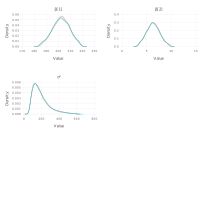

In [16]:
draw(plot(sim,:density))

In [17]:
hpd(sim) # highest posterior density intervals

4x3 Array{Any,2}:


 ""              "2.5%"     "97.5%"
 "\u3b2[1]"   185.19     218.882   
 "\u3b2[2]"     3.09828    9.45842 
 "\u3c3\ub2"   43.1949   453.6     

In [18]:
dic(sim)

Chain 1:   0% [0:00:03 of 0:00:03 remaining]
Chain 1:  10% [0:00:00 of 0:00:00 remaining]
Chain 1:  20% [0:00:00 of 0:00:00 remaining]
Chain 1:  30% [0:00:00 of 0:00:00 remaining]
Chain 1:  40% [0:00:00 of 0:00:00 remaining]
Chain 1:  50% [0:00:00 of 0:00:00 remaining]
Chain 1:  60% [0:00:00 of 0:00:00 remaining]
Chain 1:  70% [0:00:00 of 0:00:00 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   0% [0:00:00 of 0:00:00 remaining]
Chain 2:  10% [0:00:00 of 0:00:00 remaining]
Chain 2:  20% [0:00:00 of 0:00:00 remaining]
Chain 2:  30% [0:00:00 of 0:00:00 remaining]
Chain 2:  40% [0:00:00 of 0:00:00 remaining]
Chain 2:  50% [0:00:00 of 0:00:00 remaining]
Chain 2:  60% [0:00:00 of 0:00:00 remaining]
Chain 2:  70% [0:00:00 of 0:00:00 remaining]
Chain 2:  80% [0:00:00 of 0:00:00 remaining]
Chain 2:  90% [0:00:00 of 0:00:00 remaining]
Chain 2: 100% [0:00:00 of 0:00:00 remaining]

Chain 3:

3x3 Array{Any,2}:
 ""      "DIC"   "Effective Parameters"
 "pD"  82.4082  2.4342                 
 "pV"  86.4382  4.44921                

In [19]:
cor(sim)

4x4 Array{Any,2}:


 ""             "\u3b2[1]"    "\u3b2[2]"    "\u3c3\ub2"
 "\u3b2[1]"    1.0          -0.841656     -0.126236    
 "\u3b2[2]"   -0.841656      1.0           0.104499    
 "\u3c3\ub2"  -0.126236      0.104499      1.0         

In [20]:
autocor(sim)

4x5x4 Array{Any,3}:
[:, :, 1] =
 

""             "Lag 2"      "Lag 10"     "Lag 20"     "Lag 100"
 "\u3b2[1]"   -0.0141382   -0.00178988   0.0162199   -0.00986842
 "\u3b2[2]"   -0.00749054  -0.034613    -0.0135389    0.00319278
 "\u3c3\ub2"  -0.00999     -0.00785608   0.00261811  -0.00522665

[:, :, 2] =
 ""             "Lag 2"      "Lag 10"    "Lag 20"     "Lag 100"
 "\u3b2[1]"   -0.019092    -0.0187611  -0.00996735   0.011593  
 "\u3b2[2]"   -0.00311127  -0.0126913  -0.0143186   -0.00603116
 "\u3c3\ub2"   0.00131213  -0.0235452  -0.00698653  -0.00737993

[:, :, 3] =
 ""             "Lag 2"      "Lag 10"    "Lag 20"    "Lag 100"
 "\u3b2[1]"    0.0252564   -0.0248235   0.00391775  0.0233838 
 "\u3b2[2]"    0.0142765   -0.0112951   0.0121663   0.0318517 
 "\u3c3\ub2"  -0.00322433  -0.0193786  -0.00113483  0.00605466

[:, :, 4] =
 ""             "Lag 2"     "Lag 10"     "Lag 20"     "Lag 100"
 "\u3b2[1]"   -0.0184579  -2.2364e-7    0.0175464    0.00881937
 "\u3b2[2]"   -0.0169411  -0.00616614   0.0118218    0.0189667 
 "

In [21]:
quantile(sim)

4x6 Array{Any,2}:


 ""              "2.5%"     "25.0%"     "50.0%"     "75.0%"     "97.5%"
 "\u3b2[1]"   184.659    197.064     202.368     207.536     218.424   
 "\u3b2[2]"     3.24934    5.33079     6.28388     7.2586      9.65467 
 "\u3c3\ub2"   68.3493   118.94      166.554     240.316     581.3     

In [22]:
summarystats(sim)

4x6 Array{Any,2}:


 ""              "Mean"     "SD"     "Naive SE"   "MCSE"         "ESS"
 "\u3b2[1]"   202.172      8.46312  0.0691011    0.0684826  15000.0   
 "\u3b2[2]"     6.32014    1.58712  0.0129587    0.0121196  15000.0   
 "\u3c3\ub2"  204.143    150.917    1.23223      1.4725     12552.4   

## A flat prior on β

As the precision matrix on the prior for `β` goes to zero (i.e. as the variance of the distribution of each component goes to ∞) the conditional distribution of `β` becomes a template distribution, `MvNormalCanon(Xty,XtX)` scaled by `σ`, making it even easier to sample.

In [23]:
Gibbs_β = Sampler([:β],
  @modelexpr(σ²,Xty,XtX, √σ² * rand(MvNormalCanon(Xty,XtX)))
);
setsamplers!(lrmod,[Gibbs_β,Gibbs_σ²]);
simulate!(lrmod)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[3423.28,100.902]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
 10.0   45.0
 45.0  285.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 3.16228  14.2302 
 0.0       9.08295)
-------------------------------------------------------------------------------
Xty:
[2310.01,10899.5]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
8.65344730719054e6
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[3423.28,3524.18,3625.08,3725.98,3826.89,3927.79,4028.69,4129.59,4230.49,4331.4]
-------------------------------------------------------------------------------
X:
10

Hmm.  Looks like I haven't got that right as the values of $\beta$ and $\mu$ look wrong.

This version is still a bit wasteful.  The fixed distribution, `MvNormalCanon(Xty,XtX)` does not need to be constructed at every iteration.  It should be created and saved as an input.

## Linear mixed-effects models

This may seem to be a lot of effort for an analysis of a simple linear regression model, given that the full posterior distribution of the parameters can be evaluated.  This is a very rare case.  For some other models the conditional distributions may be available even if the full posterior distribution is not.

A common such case is linear mixed-effects models (LMMs).  As in the linear regression model there is a linear predictor expression but here it is a conditional distribution
$$
\mathcal{Y}|\mathcal{B}={\bf b} \sim \mathcal{N}({\bf X}\beta+{\bf Zb},\sigma^2 {\bf I}_n)
$$
in which the linear predictor appears.  The unconditional distribution of $\mathcal{B}$ is a zero-mean multivariate normal with a parameterized covariance matrix.
$$
\mathcal{B}\sim\mathcal{N}({\bf 0},\Sigma_\theta)
$$
where $\theta$ is the covariance parameter.

For example, in the `Dyestuff` data from the `lme4` package for [R](http://www.r-project.org)

In [24]:
## Dyestuff data from lme4
const ds = DataFrame(Yield = 
   [1545.,1440.,1440.,1520.,1580.,1540.,1555.,1490.,1560.,1495.,
    1595.,1550.,1605.,1510.,1560.,1445.,1440.,1595.,1465.,1545.,
    1595.,1630.,1515.,1635.,1625.,1520.,1455.,1450.,1480.,1445.],
Batch = pool(rep('A':'F',1,5)));

the batches constitute a random sample from the potential batches of an intermediate product in the manufacturing process.  We are more interested in the variability induced in the `Yield` by the choice of batch than in any particular batch.

We say that the `Yield` has two "variance components", a residual variability with variance `σ²` and the variability between batches, with a variance that we will write as `σ₁²`.  The _random effects_ for the batches are a 6-dimensional vector, `b`.  In this case the only random effects are those for the batches.

In sampling theory formulation of the probability model we say that the random effects are unobserved random variables.  In the Bayesian approach everything is a random variable, including the random effects.

Random effects are always associated with a _grouping factor_, `Batch` in this case.  In general the model matrix, `Z`, for the random effect is a sparse matrix generated from the indicators for the various grouping factors.  Because of the flexibility of the Julia language and  the fact that loops do not impose a performance penalty, we do not need to create the model matrix `Z` explicitly.  We use a triplet of the grouping factor, a 'thin' model matrix and a `PDMat` object for each random effects term in the model.  (There is only one such term in our example.)

In [25]:
type ReTerm
    Zt::Matrix{Float64}
    fac::PooledDataVector
    D::MvNormalCanon
end